# Data Exploration

Using mystery genre (~10% of full dataset)

* Import reviews datasets
* Add columns for user reviews, days since review
* Explore distribution of votes and comments on reviews
* Explore distribution of votes and comments by days since review
* Explore distribution of readership (ratings, reviews, likes/comments on reviews per book)
* Explore "like share" distribution

### Takeaways for full dataset

Add columns:
* number of reviews by user
* number of days between review posting and data scraping
* number of likes (votes + comments)
* like share (review likes/book review likes)
* popularity (binary)

Filters:
* book review is in English
* book has at least 10 reviews (~60th percentile)
* book has at least 60 review likes (~55th percentile)
* review has at least 1 like


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
book_path = "data/goodreads_books_mystery.json"
review_path = "data/goodreads_reviews_mystery.json"

In [3]:
# read review data and convert to DataFrame
reviews = []
with open(review_path) as f:
    for line in f:
        reviews.append(json.loads(line))
reviews = pd.DataFrame(reviews, columns=['user_id','book_id','rating','review_text','date_added','n_votes','n_comments'])

In [4]:
# add column for number of reviews by user
reviews = reviews.join(reviews.groupby("user_id")["book_id"].count().rename("user_reviews"),on='user_id')

In [5]:
len(reviews)

1849236

In [6]:
# explore range of review dates
review_dates = pd.to_datetime(pd.to_datetime(reviews["date_added"],format='%a %b %d %H:%M:%S %z %Y',errors='coerce'),utc=True,errors='coerce')
print(min(review_dates), max(review_dates))

1943-04-01 07:00:00+00:00 2017-11-04 05:17:08+00:00


In [7]:
# add column for days between review posting and data scraping (max review date)
reviews["days_since_review"] = (max(review_dates) - review_dates).dt.days

In [8]:
# distribution of votes and comments
reviews[["n_votes","n_comments"]].quantile([.5,.65,.75,.9,.95,.99,.999])

,n_votes,n_comments
0.500,0.0,0.0
0.650,0.0,0.0
0.750,1.0,0.0
0.900,2.0,0.0
0.950,4.0,1.0
0.990,18.0,6.0
0.999,82.0,27.0


In [9]:
len(reviews[reviews["n_votes"]==0])/len(reviews)

0.7443171125805468

There are 0 votes for 75% of reviews. 95% have 4 or fewer votes. Extremely skewed distribution. I think it might make sense to remove all reviews with 0 votes and comments as these reviews are uninformative. Likely these people just don't have friends reading their reviews. Even keeping reviews with one vote in is a very skewed distribution as over 50% have only one vote. All the more reason to come up with some kind of scaled metric or categorical metric.

In [10]:
# distribution of votes and comments, filtering out 0 vote and comment reviews
reviews.loc[(reviews["n_votes"]+reviews["n_comments"])>0,["n_votes","n_comments"]].quantile([.5,.75,.9,.95,.99,.999])

,n_votes,n_comments
0.500,1.000,0.0
0.750,3.000,1.0
0.900,8.000,2.0
0.950,14.000,4.0
0.990,47.000,15.0
0.999,138.566,48.0


In [11]:
# ratio of votes to comments; comments are very rare
(reviews[reviews["n_votes"]>0]["n_comments"]/reviews[reviews["n_votes"]>0]["n_votes"]).quantile([.5,.75,.9,.95,.99,.999])

0.500    0.000000
0.750    0.000000
0.900    0.657143
0.950    1.000000
0.990    3.000000
0.999    7.000000
dtype: float64

Comments are very rare relative to likes. Comments should probably count for more, but for this project I will just add votes and comments together (1 comment = 1 vote). I don't think there will be any difference in end results for the popularity metric.

In [12]:
reviews["n_likes"] = reviews["n_votes"]+reviews["n_comments"]

In [13]:
# distribution of likes by days since review for reviews < 1 mo old
reviews.loc[reviews["days_since_review"]<30,"n_likes"].quantile([.5,.75,.9,.95,.99,.999])

0.500      0.0
0.750      1.0
0.900      3.0
0.950      7.0
0.990     27.0
0.999    114.0
Name: n_likes, dtype: float64

In [14]:
# distribution of likes by days since review for reviews < 1 year old
reviews.loc[reviews["days_since_review"]<365,"n_likes"].quantile([.5,.75,.9,.95,.99,.999])

0.500      0.0
0.750      1.0
0.900      4.0
0.950      9.0
0.990     38.0
0.999    139.0
Name: n_likes, dtype: float64

In [15]:
# distribution of likes by days since review for reviews > 1 year old
reviews.loc[reviews["days_since_review"]>365,"n_likes"].quantile([.5,.75,.9,.95,.99,.999])

0.500     0.0
0.750     1.0
0.900     2.0
0.950     5.0
0.990    20.0
0.999    91.0
Name: n_likes, dtype: float64

Number of days since review doesn't seem significant. In fact the 90th percentile is actually higher for more recent reviews than older reviews. I don't think any of these differences are significant enough to merit inclusion except perhaps as a baseline variable.

In [16]:
# select and rename final columns required from reviews set
reviews = reviews.loc[:,["book_id","user_reviews","rating","review_text","days_since_review","n_likes"]]
reviews = reviews.rename(columns={"rating": "user_rating", "n_likes": "review_likes"})

In [17]:
reviews.head()

,book_id,user_reviews,user_rating,review_text,days_since_review,review_likes
0,6392944,27,3,I haven't read a fun mystery book in a while a...,102.0,6
1,28684704,27,3,"A fun, fast paced science fiction thriller. I ...",353.0,22
2,32283133,27,0,http://www.telegraph.co.uk/culture/10...,367.0,9
3,17860739,27,4,An amazing and unique creation: JJ Abrams and ...,1318.0,7
4,8694005,27,3,The Name of the Rose is a thrilling Dan Brown-...,2613.0,23


In [18]:
# read book data and convert to DataFrame, retaining only relevant columns
books = []
with open(book_path) as f:
    for line in f:
        books.append(json.loads(line))
books = pd.DataFrame(books)
books = books.loc[:,["book_id","text_reviews_count","ratings_count","average_rating"]]
books = books.astype({'text_reviews_count': 'int64','ratings_count': 'int64','average_rating': 'float64'})

I looked at language_code and publication_year but there was a lot of missing data. Language over 50% were blank. Publication_year had about 15% missing. Given the fact that days since review didn't seem to impact the vote distribution I am going to assume that years since publication won't either.

In [19]:
# explore number of ratings distribution
books["ratings_count"].quantile([.25,.5,.75,.9,.95,.99,.999])

0.250       10.00
0.500       35.00
0.750      128.00
0.900      491.00
0.950     1225.00
0.990     7345.66
0.999    51633.56
Name: ratings_count, dtype: float64

In [20]:
books["ratings_count"].mean()

523.902410655233

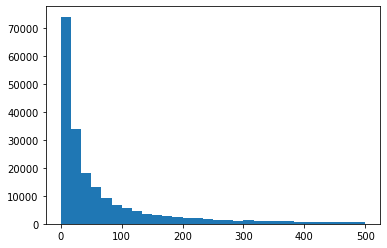

In [21]:
plt.figure()
plt.hist(books["ratings_count"],bins=30, range=(0,500))
plt.show()

Huge range in book readership. Review popularity will have to be adjusted for book popularity.

In [22]:
# explore number of reviews distribution
books["text_reviews_count"].quantile([.25,.5,.63,.75,.9,.95,.99,.999])

0.250       2.000
0.500       6.000
0.630      10.000
0.750      17.000
0.900      51.000
0.950     109.000
0.990     517.000
0.999    2608.362
Name: text_reviews_count, dtype: float64

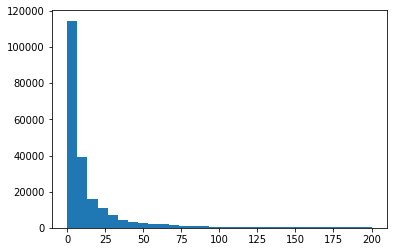

In [23]:
plt.figure()
plt.hist(books["text_reviews_count"],bins=30, range=(0,200))
plt.show()

In [24]:
books[["text_reviews_count","ratings_count"]].corr('pearson')

,text_reviews_count,ratings_count
text_reviews_count,1.000000,0.740515
ratings_count,0.740515,1.000000


In [25]:
# join review and book sets
books = books.rename(columns={"text_reviews_count":"book_reviews", "ratings_count":"book_ratings", "average_rating":"avg_rating"})
dat = pd.merge(reviews,books,on="book_id")

In [26]:
dat.head()

,book_id,user_reviews,user_rating,review_text,days_since_review,review_likes,book_reviews,book_ratings,avg_rating
0,6392944,27,3,I haven't read a fun mystery book in a while a...,102.0,6,42,675,3.8
1,6392944,130,4,"A fun, fast read! I just adore reading books w...",2324.0,0,42,675,3.8
2,6392944,36,4,"Full of twists and turns, way better than the ...",1164.0,0,42,675,3.8
3,6392944,15,4,The Murder on the Links is Agatha Christie's s...,1011.0,1,42,675,3.8
4,6392944,41,3,I enjoyed this novel. It is the epitome of a m...,216.0,0,42,675,3.8


In [27]:
# add total review likes for book
dat = dat.join(dat.groupby("book_id")["review_likes"].sum().rename("book_review_likes"),on='book_id')

In [28]:
# explore total review likes distribution
dat["book_review_likes"].quantile([.25,.5,.55,.6,.75,.9,.95,.99,.999])

0.250        6.0
0.500       43.0
0.550       60.0
0.600       83.0
0.750      240.0
0.900     1320.0
0.950     2786.0
0.990    10578.0
0.999    17804.0
Name: book_review_likes, dtype: float64

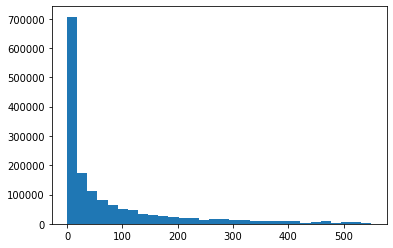

In [29]:
plt.figure()
plt.hist(dat["book_review_likes"],bins=30, range=(0,550))
plt.show()

In [30]:
# explore review likes distribution for books with more than 10 reviews
dat[dat["book_reviews"]>=10]["book_review_likes"].quantile([.05,.10,.25,.5,.75,.9,.95,.99,.999])

0.050        1.0
0.100        2.0
0.250       12.0
0.500       62.0
0.750      306.0
0.900     1603.0
0.950     3036.0
0.990    10578.0
0.999    17804.0
Name: book_review_likes, dtype: float64

In [31]:
# explore review counts distribution for books with at least 60 review likes
dat[dat["book_review_likes"]>=60]["book_reviews"].quantile([.01,.05,.10,.25,.5,.75,.9,.95,.99,.999])

0.010       33.0
0.050       96.0
0.100      174.0
0.250      478.0
0.500     1279.0
0.750     3945.0
0.900    15764.0
0.950    27346.0
0.990    78438.0
0.999    78438.0
Name: book_reviews, dtype: float64

In [32]:
# remove books with fewer than 10 reviews and books with fewer than 60 review likes
dat = dat[(dat["book_reviews"]>=10) & (dat["book_review_likes"]>=60)]

In [33]:
# add review share - number of likes for review out of number of likes on all reviews for book
dat["likes_share"] = dat["review_likes"]/dat["book_review_likes"]

In [34]:
# explore like share distribution
dat["likes_share"].quantile([.25,.5,.75,.9,.95,.99,.999])

0.250    0.000000
0.500    0.000000
0.750    0.000587
0.900    0.012821
0.950    0.032520
0.990    0.183206
0.999    0.797103
Name: likes_share, dtype: float64

In [35]:
# explore like share distribution, at least 1 like
dat.loc[dat["review_likes"]>0,"likes_share"].quantile([.25,.5,.75,.9,.95,.99,.999])

0.250    0.001869
0.500    0.007246
0.750    0.020833
0.900    0.064516
0.950    0.133333
0.990    0.503297
0.999    0.960169
Name: likes_share, dtype: float64

I am leaning towards calling a review popular if it is in the top quarter of like shares which would be share of 2%.

In [36]:
# remove books with 0 likes as mentioned eariler
dat = dat[dat["review_likes"]>0]

In [37]:
len(dat)

233469

In [38]:
# English reviews only
# https://fasttext.cc/docs/en/language-identification.html
# https://towardsdatascience.com/benchmarking-language-detection-for-nlp-8250ea8b67c
import fasttext

In [39]:
language_model = fasttext.load_model('lid.176.bin')

In [40]:
pred = language_model.predict(dat["review_text"].str.replace('\n','').to_list())

In [41]:
keep_ind = [i for i in range(len(pred[0])) if pred[0][i][0] == '__label__en' and pred[1][i][0] > .90]

In [42]:
dat = dat.iloc[keep_ind,].reset_index(drop=True)

In [43]:
len(dat)

208350

In [44]:
dat.head()

,book_id,user_reviews,user_rating,review_text,days_since_review,review_likes,book_reviews,book_ratings,avg_rating,book_review_likes,likes_share
0,28684704,27,3,"A fun, fast paced science fiction thriller. I ...",353.0,22,1026,13990,4.1,1010,0.021782
1,28684704,35,5,"Mind-bending and completely unique, take a cha...",432.0,13,1026,13990,4.1,1010,0.012871
2,28684704,5,2,This could have been so much better. If it had...,432.0,2,1026,13990,4.1,1010,0.001980
3,28684704,69,3,I have mixed feelings about this book. I feel ...,201.0,3,1026,13990,4.1,1010,0.002970
4,28684704,12,5,Fuck it. This book deserves all the stars I ca...,424.0,2,1026,13990,4.1,1010,0.001980
